In [2]:
import numpy as np
from numpy import array
from pickle import load
from pickle import dump
import collections 
import glob
import keras 
import nltk
from keras.preprocessing.image import img_to_array

from os import listdir

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

from keras.preprocessing.image import load_img




In [1]:
# VGG16 features
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
def extract_features(path):
  model=VGG16()
  model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
  img_features=dict()
  print(model.summary)
  for name in listdir(path):
    p=path+'/'+name
    image=load_img(p,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    predict=model.predict(image)
    image_id=name
    img_features[image_id]=predict
  return img_features
path='Flicker8k_Dataset'
img_features=extract_features(path)
dump(img_features,open('img_features.pkl','wb'))


Using TensorFlow backend.


In [3]:
def load_file(path):
  file=open(path,'r')
  read_text=file.readlines()
  file.close()
  return read_text

In [4]:
def read_file(path):
  read_text=load_file(path)
  img=dict()
  for l in read_text:
    imag_name=l.split()
    img_id=imag_name[0].split('#')[0].split('.')[0]
    desc=imag_name[1:]
    if img_id not in img:
      img[img_id]=list()
    img[img_id].append(desc)
    #print(img_id)
  return img

path='Flickr8k_text/Flickr8k.token.txt'
#img=read_file(path)
#print(img)


In [5]:
from nltk.tokenize import RegexpTokenizer

def clean_data():
  vocab=set()
  new_data=dict()
  sentences=open('sentences.txt','a')
  for key in img.keys():
    l=img[key]
    new_data[key]=list()
    for l1 in l:
      l1 = [word.lower() for word in l1]
      tokenizer = RegexpTokenizer(r'\w+')
      l1 = [''.join(tokenizer.tokenize(word)) for word in l1]
      l1 = [word for word in l1 if len(word)>1]
      l1 = [word for word in l1 if word.isalpha()]
      for w in l1:
        vocab.add(w)
      string=''
      for w in l1:
        string+=w+' '
      new_data[key].append(l1)
      sentences.write(key+' '+string+'\n')
  return new_data,vocab
      #print(l1)
      
#img_data,vocab=clean_data()

In [6]:
def read_model_file(path):
  read_text=load_file(path)
  data=set()
  for l in read_text:
    data.add(l)
  return data

In [7]:
def read_train_file(path):
  read_text=load_file(path)
  train_images=list()
  for l in read_text:
    l=l.split('\n')[0].split('.')[0]
    train_images.append(''.join(l))
  return train_images
# path='Flickr8k_text/Flickr_8k.trainImages.txt'
# train_images=read_train_file(path)
# print(train_images)

In [ ]:
def read_desc(path,data):
  read_text=load_file(path)
  sentence=dict()
  for l in read_text:
    imag_name=l.split()
    img_id=imag_name[0].split('#')[0]
    desc=imag_name[1:]
    if img_id in data:
      if img_id not in sentence:
        sentence[img_id]=list()
      string=''
      for word in desc:
        string+=word+" "
      desc='startseq '+string+'endseq'
      sentence[img_id].append(desc)
  return sentence
# path='/content/sentences.txt'
# sentence=read_desc(path,train_images)    

In [ ]:
def read_img_features(train_images):
  #path='/content/drive/MyDrive/AI_project/'
  feature=load(open('features.pkl','rb'))
  train_img_feature = {k: feature[k] for k in train_images}
  return train_img_feature
# train_img_features=read_img_features(train_images)

In [8]:
#Encode text to numbers
from keras.preprocessing.text import Tokenizer
def text_to_num(sentence):
  l=list()
  max_length=0
  for key in sentence.keys():
    for sent in sentence[key]:
      l.append(sent)
  print(l)
  print(len(l))
  max_length=max(len(d.split()) for d in l)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(l)
  return tokenizer,max_length

# token,max_length=text_to_num(sentence)
# print(token)


In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def sequences(token,max_len,sentence,img_features,vocab):
    img_seq=[]
    text_seq=[]
    out_seq=[]
    for key in sentence.keys():
        line=sentence[key]
        for l in line:
            seq=token.texts_to_sequences([l])[0]
            for j in range(1,len(seq)):
                seq1=seq[:j]
                seq2=seq[j]
                seq1=pad_sequences([seq1],maxlen=max_len)[0]
                seq2=to_categorical([seq2],num_classes=vocab_size)[0]
                img_seq.append(img_features[key][0])
                text_seq.append(seq1)
                out_seq.append(seq2)
    return img_seq,text_seq,out_seq
 


In [7]:

filename = 'Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [12]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [17]:
def define_model_par_inject(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3= add([fe2,se2])
    se4 = LSTM(256)(se3)
    #decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(se4)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


In [18]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_file(filename)
print('Dataset: %d' % len(train))
train_descriptions = read_desc('sentences.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = photo_features('Xception_features.pkl', train)
print('Photos: train=%d' % len(train_features))

tokenizer,max_length = text_to_num(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
print('Description Length: %d' % max_length)
img_seq_train,text_seq_train,out_seq_train = sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)


filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_file(filename)
print('Dataset: %d' % len(test))

test_descriptions = read_desc('sentences.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

test_features = photo_features('Xception_features.pkl', test)
print('Photos: test=%d' % len(test_features))

img_seq_test,text_seq_test,out_seq_test = sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)
 
model = define_model(vocab_size, max_length)

filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model.fit([img_seq_train,text_seq_train], out_seq_train, epochs=6, verbose=2, callbacks=[checkpoint], validation_data=([img_seq_test,text_seq_test],out_seq_test ))


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [ ]:
from pickle import dump
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [10]:
def get_id(integer, tokenizer):
    for w, i in tokenizer.word_index.items():
        if i == integer:
            return w
    return None

In [ ]:
def get_desc(model, token, test_img_feature, max_length):
    start = 'startseq '
    for i in range(max_length):
        seq = token.texts_to_sequences([start])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        out1 = model.predict([test_img_feature,seq], verbose=0)
        out1 = argmax(out1)
        w = get_id(out1, token)
        if w is None:
            break
        start += w+' '
        if w == 'endseq':
            break
    return start

In [11]:
# function to evaluate  model
def evaluate_model(model, descriptions, test_img_feature, tokenizer, max_length):
    real, pred = list(), list()
    for key, d_l in descriptions.items():
        out = get_desc(model, tokenizer, test_img_feature[key], max_length)
        out1 = [d.split() for d in d_l]
        real.append(out1)
        pred.append(out.split())
    print('BLEU-1 score: %f' % corpus_bleu(real, pred, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(real, pred, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(real, pred, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(real, pred, weights=(0.25, 0.25, 0.25, 0.25)))

In [21]:
from keras.models import load_model
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
import pickle
#from keras.models import load_model

filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = read_desc('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

test_features = photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
 
filename = 'model-ep003-loss3.632-val_loss3.866.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1 score:  0.4028189374774124 
BLEU-2 score:  0.2177655795698062 
BLEU-3 score:  0.14954234288161417 
BLEU-4 score:  0.06297440358052132


In [22]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img

from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

def extract_single_image_features(path):
  model=VGG16()
  model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
  img_features=dict()
  print(model.summary)
  p=path
  image=load_img(p,target_size=(224,224))
  image=img_to_array(image)
  image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  image=preprocess_input(image)
  predict=model.predict(image)
  image_id=p
  img_features[image_id]=predict
  return img_features


<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f935fe79490>>
['two', 'children', 'are', 'playing', 'in', 'the', 'water']


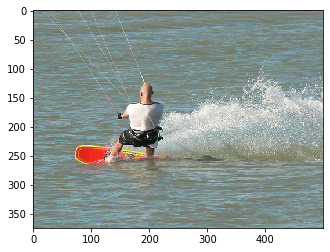

In [23]:

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
pil_im = Image.open('t1.jpg', 'r')
imshow(np.asarray(pil_im))

photo = extract_single_image_features('t1.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
description=description.split()[1:-1]
print(description)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f9359e20590>>
['dog', 'is', 'running', 'through', 'the', 'grass']


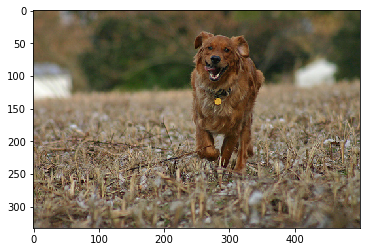

In [24]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
pil_im = Image.open('t2.jpg', 'r')
imshow(np.asarray(pil_im))

photo = extract_single_image_features('t2.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
description=description.split()[1:-1]
print(description)

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f936326fe90>>
['man', 'in', 'red', 'shirt', 'is', 'jumping', 'on', 'rock']


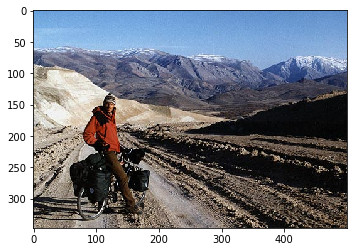

In [25]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
%matplotlib inline
pil_im = Image.open('t3.jpg', 'r')
imshow(np.asarray(pil_im))

photo = extract_single_image_features('t3.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
description=description.split()[1:-1]
print(description)